# Поиск наиболее близких товаров.

### Постановка задачи.

Есть несколько файлов содержаших данные о товарах Винк (далее для простоты "наши товары") и данные о товарах конкурирующих магазинов.
Нужно построить модель , которая по данным о товаре конкурентов будет предсказывать наиболее близкий наш товар.
Для проверки модели предоставлен список соответствий составленных вручную.


Предоставленные данные
- Товары конкурентов (слухи и парсинг - источник).csv (Основной файл с данными о товарах конкурентов)
- Товары конкурентов (счета - источник).csv
- Список наших товаров.csv (Основной файл с данными о наших товарах)
- Наши товары с артикулом.csv
- Наши товары  с категорями.xls
- Сметченные позиции 1.csv
- Сметченные позиции 2.csv
- Сметченные_позиции_слухи_и_парсинг_2_0_с_наименованием.csv
- Сметченные_счета_с_наименованиями.csv

Описание полей.
 
 1) сметченные позиции 1
 - id,
 - "match_type", - тип сопоставления. Есть три типа сопоставления товаров: аналог, точное соответствие и нет сопоставления
 - "competitor_product_id",  - id товара конкурента
 - "review_status", - это тип валидации. После сопоставления каждое сопоставление дополнительно проверяется, соответсвенно смотрим на статус
 - "validated" - значит метчинг проверили 2 раза и он сопоставлен. 
 - "sku_id", - id нашего товара
 - "measurement_coefficient" -  коэффициент пересчета из базовой единицы измерения товара (уникальной для каждого SKU) в текущую единицу. Применяется для конвертации, например, рулонов в квадратные метры или в погонные метры.

2) сметченные позиции 2
 - id,
 - "match_status",  это тип валидации. После сопоставления каждое сопоставление дополнительно проверяется, соответсвенно смотрим на статус
 - "validated" - значит метчинг проверили 2 раза и он сопоставлен. 
 - "match_type", тип сопоставления. Есть три типа сопоставления товаров: аналог, точное соответствие и нет сопоставления
 - "sku_id"- id нашего товара
 - "invoice_item_id",- id товара конкурента
 - "measurement_coefficient"  - коэффициент пересчета из базовой единицы измерения товара (уникальной для каждого SKU) в текущую единицу. Применяется для конвертации, например, рулонов в квадратные метры или в погонные метры.

3) Список наших товаров
 - sku_id, - id нашего товара
 - "sku_name" - наименование нашего товара 
 - "unit",  - единица измерения 
 - "net_weight_base_unit" - вес 
 - "length_base_unit", - длина
 - "width_base_unit", - ширина
 - "height_base_unit" - высота

 4) Товары конкурентов (слухи и парсинг - источник)
 - id,
 - "article"- артикул товара конкурента 
 - "name" - наименование товара конкурента
 - "characteristics" - характеристики товара конкурента
 - "name" - единица измерения
 - "info_source"- источник (слухи или парсинг)

 5) Товары конкурентов (счета - источник)
 - id,
 - "article_number" - артикул товара конкурента 
 - "product_name"- наименование товара конкурента
 - "name" - единица измерения

### План работы

Первая часть работы будет посвещена загрузке и обработке данных.
Поскольку дано много файлов данных с разными полями, будем последовательно загружать, изучать их приводя к одинаковому формату. Одновременно с этим будет удалять дубликаты и подозрительные записи. В итоге в конце главы получим 3 датафрейма.
- df данные о товарах конкурентов
- df_us данные о наших товарах
- df_match данные о соответствиях между товарами для проверки модели.
  
Вторая часть работы посвещена созданию модели для предсказания.

В заключительной части делаются выводы и даеются рекомендации.

### Загрузка библиотек

In [93]:
!pip install xlrd
!pip install gensim 
!pip install pymorphy3
!pip install nltk

In [94]:
import pandas as pd
import re
import random
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import numpy as np
from numpy.linalg import norm
from gensim.models import FastText
import matplotlib.pyplot as plt
# Импорт для стемминга и лемматизации
import pymorphy3
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import nltk
import joblib

# Загружаем словари WordNet
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [95]:
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 100
DIR = 'D:\\Matching\\'

### Загрузка данных

Всего заказчиком предоставлено 11 файлов данных. Будем загружать последовательно и разбираться с содержимым.

#### Товары конкурентов (слухи и парсинг - источник)

Основной файл даных про товары конкурентов.

In [96]:
df = pd.read_csv(DIR+"Товары конкурентов (слухи и парсинг - источник).csv")
df.head()

,id,article,name,characteristics,name.1,info_source
0,1,340 г 300*500 ламинированный GLP,340 г 300*500 ламинированный GLP,Наименование / Цвет/ Плотность / размер / наименование торговой марки / другие особенности (сост...,м2,rumor
1,2,440 г 1000*1000 литой GLP,440 г 1000*1000 литой GLP,Наименование / Цвет/ Плотность / размер / наименование торговой марки / другие особенности (сост...,м2,rumor
2,3,не знаю,МТ-95,"МТ-95 ширины 0,5 и 1,22",м2,rumor
3,4,"641 серебряная серая 1,26 м ширина","641 серебряная серая 1,26 м ширина","641 серебряная серая 1,26 м ширина",м2,rumor
4,5,рпопоп,баннер,Наименование / Цвет/ Плотность / размер / наименование торговой марки / другие особенности (сост...,м2,rumor


info_source может быть либо парсер либо слухи.

In [97]:
df.pivot_table(index='info_source',values = 'name', aggfunc = 'count')

,name
info_source,
parser,44977
rumor,54


Слухи источник не надежный и таких записей мало, по этому можно оставить только данные парсера. 

In [98]:
df = df.loc[df['info_source']=='parser']

In [99]:
df.sample(5)

,id,article,name,characteristics,name.1,info_source
14569,14460,"BASEL-10-10-GO (INFR 10-10G) втулка золото глянц.,диам.10*10мм BASEL-10-10-GO (INFR 10-10G) втул...","BASEL-10-10-GO (INFR 10-10G) втулка золото глянц.,диам.10*10мм BASEL-10-10-GO (INFR 10-10G) втул...",Вес: ; Длина: ; Ширина: ; Высота:,шт,parser
17259,17157,"Труба Plexiglas® XT clear 110*104 мм, 4.0 м, 4,8 кг.","Труба Plexiglas® XT clear 110*104 мм, 4.0 м, 4,8 кг.",Вес: ; Длина: ; Ширина: ; Высота:,шт,parser
37867,37612,"Лист ABS Transply 0,8мм Indoor мат/гл, 141 opal светорассеивающий, 3,0 м, 2.0 м, 18,9 кг.","Лист ABS Transply 0,8мм Indoor мат/гл, 141 opal светорассеивающий, 3,0 м, 2.0 м, 18,9 кг.",Вес: ; Длина: ; Ширина: ; Высота:,шт,parser
43976,43900,"Пленка Oraguard 200 SG, 000, 50 м, 1,37 м, 14,05 кг.","Пленка Oraguard 200 SG, 000, 50 м, 1,37 м, 14,05 кг.",Вес: ; Длина: ; Ширина: ; Высота:,пог. м,parser
11581,11471,"Профиль алюминиевый Уголок 10 х 10 х 1 мм, анодированный серебро, длина 3 м","Профиль алюминиевый Уголок 10 х 10 х 1 мм, анодированный серебро, длина 3 м",Вес: ; Длина: ; Ширина: ; Высота:,шт,parser


Проверим также столбец с единицами измерений `name.1`

In [100]:
df.pivot_table(index='name.1',values = 'name', aggfunc = 'count').T

name.1,л,м,м2,пог. м,рул,упак,шт
name,1140,240,1128,15157,2968,823,23521


In [101]:
df.loc[df['name.1']=='л'].sample(10)

,id,article,name,characteristics,name.1,info_source
2757,5487,"УФ-отверждаемые чернила STARINK UV KTR Soft светлая маджента (LM), 1 л","УФ-отверждаемые чернила STARINK UV KTR Soft светлая маджента (LM), 1 л",Вес: ; Длина: ; Ширина: ; Высота:,л,parser
5324,967,Композитная панель BILDEX матовая (9005 1500x4000 3-0.3мм черный),Композитная панель BILDEX матовая (9005 1500x4000 3-0.3мм черный),NaN,л,parser
4634,281,Искусственные растения (CCGA143M 100х100см green dream (мечта)),Искусственные растения (CCGA143M 100х100см green dream (мечта)),NaN,л,parser
6755,2408,АКЦИЯ - ПВХ белый UNEXT 3050х1560х3 мм STRONG,АКЦИЯ - ПВХ белый UNEXT 3050х1560х3 мм STRONG,NaN,л,parser
2818,5547,"УФ-отверждаемые чернила ARISTA S, циан (C), 1 л","УФ-отверждаемые чернила ARISTA S, циан (C), 1 л",Вес: ; Длина: ; Ширина: ; Высота:,л,parser
4678,325,Композитная панель BILDEX матовая (3020 1500x4000 3-0.2мм красный),Композитная панель BILDEX матовая (3020 1500x4000 3-0.2мм красный),NaN,л,parser
5365,1008,Поликарб. сот NOVATTRO 12000х2100х4 мм прозр.,Поликарб. сот NOVATTRO 12000х2100х4 мм прозр.,NaN,л,parser
2785,5515,"УФ-отверждаемые чернила STARINK UV Hard лак (V), 1 л","УФ-отверждаемые чернила STARINK UV Hard лак (V), 1 л",Вес: ; Длина: ; Ширина: ; Высота:,л,parser
6596,2245,Декоративный пластик SIBU Deco-Line Display Mirror (DM Brass AR SA 1000x2600x1.13),Декоративный пластик SIBU Deco-Line Display Mirror (DM Brass AR SA 1000x2600x1.13),NaN,л,parser
6798,2450,3000х2000х3мм зеленый CH 347 REXGLASS XT У,3000х2000х3мм зеленый CH 347 REXGLASS XT У,NaN,л,parser


Видим, что 'л' это у нас и листы и литры. Что не очень хорошо. Нужно поменять настройки парсера. 

Проверим что `article` и `name` совпадают.	

In [102]:
df.loc[df['article']==df['name'],'id'].count() == df.shape[0]

True

Видим, что информативный столбец `name` и `name.1`.

In [103]:
df = df[['name','name.1']]

Посмотрим наличие дубликатов и удалим их.

In [104]:
df.duplicated().sum()

1781

In [105]:
df = df.drop_duplicates()

Заметим при этом что дубликаты по именам остаются.

In [106]:
df.loc[df['name'].duplicated(keep=False)]

,name,name.1
434,ORALITE 6710-080,рул
435,ORALITE 6710-060,рул
436,ORALITE 6710-050,рул
437,ORALITE 6710-035,рул
438,ORALITE 6710-030,рул
439,ORALITE 6710-020,рул
440,ORALITE 6710-010,рул
18372,ORALITE 6710-020,пог. м
18485,ORALITE 6710-030,пог. м
43675,ORALITE 6710-010,пог. м


Переименуем колонки

In [107]:
df = df.rename(columns={'name.1':'units'})
df.head(1)

,name,units
18,Композитная панель GROSSBOND металлик (G9007 1500x4000 3-0.3мм мокрый асфальт),л


##### Вывод

Датафрейм почищен от ненужных столбцов и дубликатов , готов к дальнейшей обработке.

#### Товары конкурентов (счета - источник)

Дополнение к основному файлу данных о товарах конкурентов. После обработки добавим эти данные к df.

In [108]:
df_2 = pd.read_csv(DIR+"Товары конкурентов (счета - источник).csv")
df_2.head()

,id,article_number,product_name,name
0,11,ПВХ Unext-Fresh 2030х3050х8мм белый,ПВХ Unext-Fresh 2030х3050х8мм белый,лист
1,10,ПВХ Unext-Fresh 2030х3050х6мм белый,ПВХ Unext-Fresh 2030х3050х6мм белый,лист
2,9,ПВХ Unext-Fresh 2030х3050х4мм белый,ПВХ Unext-Fresh 2030х3050х4мм белый,лист
3,8,ПВХ Unext-Fresh 2030х3050х2мм белый,ПВХ Unext-Fresh 2030х3050х2мм белый,лист
4,24,"Пленка Oracal 641 (G, 047, 50 м, 1.26 м, 16,002 кг.)","Пленка Oracal 641 (G, 047, 50 м, 1.26 м, 16,002 кг.)",рул


In [109]:
df_2.shape[0]

461

In [110]:
df_2.loc[df_2['article_number']!=df_2['product_name']]

,id,article_number,product_name,name
6,12,"Пленка ORACAL641 (1,26 м) 10 (641 1,26х50)","Пленка ORACAL-641 (1,26 м) 10 (641 1,26х50)",пог. м
7,25,"Пленка ORACAL641 (1,26 м) 21 (641 1,26х50)","Пленка ORACAL-641 (1,26 м) 21 (641 1,26х50)",пог. м
8,26,"Пленка ORACAL641 (1,26 м) 70 (641 1,26х50)","Пленка ORACAL-641 (1,26 м) 70 (641 1,26х50)",пог. м
12,6,03PDL80JYY105000,"Самоклеящаяся пленка для ламинирования DLC LAM 1003 1,05 x 50 м, прозрачная, матовая",пог. м
13,7,03PDL80JYY125000,"Самоклеящаяся пленка для ламинирования DLC LAM 1003 1,26 x 50 м, прозрачная, матовая",пог. м
35,408,03PPR80GNA105000,"Самоклеящаяся пленка Prento 80 1,06 x 50 м, молочно-белая, глянцевая",пог. м
36,409,03PPR80MNA105000,"Самоклеящаяся пленка Prento 80 1,06 x 50 м, молочно-белая, матовая",пог. м
42,379,TPP-10-K-P-M,"Пленка самоклеящаяся GLP прозрачная для печати 100 мк, подложка плотностью 140 г/м2 1.27х50 матовая",рул
43,397,"HF530_3,2","ПВХ баннерная ткань HLD холодный ламинат Фронтлит 300х500 D 18х9 3,2х50 м 440 г/м2 матовая",рул
44,398,"HF530_2,2","ПВХ баннерная ткань HLD холодный ламинат Фронтлит 300х500 D 18х9 2,2х50 м 440 г/м2 матовая",рул


Оставляем столбец `product_name`	`name`. Удаляем записи с именами: тест,тесмт,есрпви,тмр,тест76. Переименуем столбцы согласно с df.

In [111]:
df_2 = df_2[['product_name','name']]
df_2 = df_2.loc[~df_2['product_name'].isin(['тест','тесмт','есрпви','тмр','тест76'])]
df_2 = df_2.rename(columns={'product_name':'name','name':'units'})

In [112]:
df_2.pivot_table(index='units',values = 'name', aggfunc = 'count').T

units,л,лист,м2,пог. м,рул,шт
name,3,25,97,74,33,223


In [113]:
df_2.head(1)

,name,units
0,ПВХ Unext-Fresh 2030х3050х8мм белый,лист


Объединим добавим df_2 к df

In [114]:
df_3 = pd.concat([df,df_2])
df_3.shape[0] == df_2.shape[0]+df.shape[0]

True

In [115]:
df = df_3.drop_duplicates()

Посмотрим короткие имена.

In [116]:
df.loc[df['name'].str.len()<11]

,name,units
23,Веер 970,шт
3097,Уголок FL,шт
5214,Веер 641,шт
5690,Резка АКП,пог. м
5719,Пружина FL,шт
183,Инструмент,шт


In [117]:
df['name'].duplicated().sum()

18

##### Вывод

Очистили Товары конкурентов (счета - источник) от лишнего и добавили к df

#### Список наших товаров

Основной файл с данными о наших товарах.

In [118]:
df_us = pd.read_csv(DIR+"Список наших товаров.csv")
df_us.head()

,sku_id,sku_name,unit,net_weight_base_unit,length_base_unit,width_base_unit,height_base_unit
0,3fafee0a-8176-11ef-8edc-000c2963e42a,"Тканевый стенд Expoline, 596*49*228 см, прямой, односторонний + сумка",ШТ.,36150.0,596.0,49.0,228.0
1,3fafee0a-8176-11ef-8edc-000c2963e42a,"Тканевый стенд Expoline, 596*49*228 см, прямой, односторонний + сумка",шт,36150.0,596.0,49.0,228.0
2,3bfe1dbe-67b0-11e3-ba5e-003048728e39,"Пленка антигравийная Oraguard 280 G 000 0,63*10 м полиуретан для авто, прозрачная, глянцевая",рул,2646.0,0.0,0.0,0.0
3,1f836658-6138-11eb-823b-000c29083909,"Баннер короткий Vikuflex литой Frontlit 440 г, 1,37*30 м полумат 1000D*1000D, 16*16",рул,18100.0,137.0,16.0,16.0
4,6f0681ac-2976-11ef-8ea7-000c29aa3e57,"Резьбовой фиксатор анаэробный Akfix L270, высокая прочность, 250 мл",ШТ.,300.0,9.5,4.5,22.5


Опять оставляем только имя и единицы.

In [119]:
df_us = df_us.rename(columns={'sku_name':'name','unit':'units'})
df_us = df_us[['name','units']]

In [120]:
df_us.pivot_table(index='units',values = 'name', aggfunc = 'count').T

units,Нечто,ШТ.,бухта,кг,кор,л,лист,м,м2,м3,пог. м,рул,упак,шт
name,10,19101,43,382,4,15,116,51,88,2,129,12442,346,19101


Нечто переведем в шт, ШТ. в шт , бухту в упаковку , кор в упаковку.

In [121]:
df_us.loc[df_us['units']=='кор','units'] = 'упак'
df_us.loc[df_us['units']=='бухта','units'] = 'упак'
df_us.loc[df_us['units']=='ШТ.','units'] = 'шт'
df_us.loc[df_us['units']=='Нечто','units'] = 'шт'
df_us.pivot_table(index='units',values = 'name', aggfunc = 'count').T

units,кг,л,лист,м,м2,м3,пог. м,рул,упак,шт
name,382,15,116,51,88,2,129,12442,393,38212


Дубликаты смотрим и удаляем

In [122]:
df_us.duplicated().sum()

19250

ШТ. и шт были полностью дублированы. Причину этого нужно исправить на стороне заказчика.

In [123]:
df_us = df_us.drop_duplicates()
df_us.shape

(32584, 2)

Посмотрим короткие имена

In [124]:
df_us.loc[df_us['name'].str.len()<10]

,name,units
411,ND 51050,упак
577,Картины,шт
1754,тест,шт
2258,Ремень,шт
5794,Кепка KDX,шт
6061,Кулер,шт
6338,Помпа,шт
7519,Мойка,шт
7750,Тумба БУ,шт
10659,Комод,шт


Видим, что есть весьма общие наименования. Есть так же тест2, тест4, v, test, тест, ТЕСТ удалим их.

In [125]:
df_us = df_us.loc[~df_us['name'].isin(['тест2', 'тест4', 'v', 'test', 'тест', 'ТЕСТ'])].dropna()
df_us.shape

(32576, 2)

##### Вывод

Датафрейм с нашими товарами очишен и готов к использованию.

#### Наши товары с артикулом

Проводим аналогичные операции.

In [126]:
df_us2 = pd.read_csv(DIR+"Наши товары с артикулом.csv")
df_us2.head()

,sku_id,article,item_name,group_name,width_base_unit,length_base_unit,height_base_unit,net_weight_base_unit
0,3fafee0a-8176-11ef-8edc-000c2963e42a,р6660,"Тканевый стенд Expoline, 596*49*228 см, прямой, односторонний + сумка",мобильные стенды стендформат,49.0,596.0,228.0,36150.0
1,3bfe1dbe-67b0-11e3-ba5e-003048728e39,н3164,"Пленка антигравийная Oraguard 280 G 000 0,63*10 м полиуретан для авто, прозрачная, глянцевая",антигравийка,0.0,0.0,0.0,2646.0
2,1f836658-6138-11eb-823b-000c29083909,о4037,"Баннер короткий Vikuflex литой Frontlit 440 г, 1,37*30 м полумат 1000D*1000D, 16*16",баннер короткие рулоны 1,16.0,137.0,16.0,18100.0
3,6f0681ac-2976-11ef-8ea7-000c29aa3e57,р4549,"Резьбовой фиксатор анаэробный Akfix L270, высокая прочность, 250 мл",продукция akfix,4.5,9.5,22.5,300.0
4,17b12d70-e37f-11ea-bb11-000c29083909,о3254,"Ткань Неопрен Термотрансфер 300 гр/кв м, 1.5 м, 25,6 пог/м",спорт текстиль рф,0.0,0.0,0.0,0.0


In [127]:
df_us2.shape

(32981, 8)

Количество записей не совпадает с df_us проверим чего нехватает.

In [128]:
df_us_delta = df_us2.loc[~df_us2['item_name'].isin(df_us['name'])]
df_us_delta.head()

,sku_id,article,item_name,group_name,width_base_unit,length_base_unit,height_base_unit,net_weight_base_unit
1099,b8724fe8-2084-11ee-859f-000c294ae96a,о9763,тест,образцы подрядов,0.0,0.0,0.0,0.0
4778,08325b65-2c46-11ee-934e-000c294ae96a,о9850,тест,образцы,205.0,305.0,0.4,13000.0
5649,ccfa4ac6-e280-11e8-bef5-000c293bb9ea,о0070,"Набор насадок Uzlex из микрофибры на эргономичный ракель, 217*33 мм, (3 шт./упак.) 21910019",инструмент uzlex,0.0,0.0,0.0,300.0
7857,5ab5137d-fc1d-11eb-95df-000c29083909,о5613,тест,прочее,0.0,0.0,0.0,0.0
9768,cc0d6b3a-3f3b-11e9-86b7-000c29083909,о0465,тест,образцы,0.0,0.0,0.0,0.0


Проверяем короткие имена.

In [129]:
df_us_delta.loc[df_us_delta['item_name'].str.len()<15]

,sku_id,article,item_name,group_name,width_base_unit,length_base_unit,height_base_unit,net_weight_base_unit
1099,b8724fe8-2084-11ee-859f-000c294ae96a,о9763,тест,образцы подрядов,0.0,0.0,0.0,0.0
4778,08325b65-2c46-11ee-934e-000c294ae96a,о9850,тест,образцы,205.0,305.0,0.4,13000.0
7857,5ab5137d-fc1d-11eb-95df-000c29083909,о5613,тест,прочее,0.0,0.0,0.0,0.0
9768,cc0d6b3a-3f3b-11e9-86b7-000c29083909,о0465,тест,образцы,0.0,0.0,0.0,0.0
17917,f200b481-e991-11e4-882b-000c2900a85f,н4287,Печать графики,NaN,NaN,NaN,NaN,NaN
21010,ce02216e-2534-11ee-a5ad-000c294ae96a,р0001,ТЕСТ,foamlite eco,0.0,0.0,0.0,0.0
21192,eb920134-4418-11dd-bba4-005056c00008,4651,v,сотовый пк,0.0,0.0,0.0,37800.0
21830,5ab51382-fc1d-11eb-95df-000c29083909,о5614,тест2,прочее,0.0,0.0,0.0,0.0
21833,5ab51387-fc1d-11eb-95df-000c29083909,о5615,тест4,монолитный пк,0.0,0.0,0.0,0.0
23341,89428272-f2fa-11e4-b3c5-000c2900a85f,н4323,Дизайн макета,NaN,NaN,NaN,NaN,NaN


Удалим тесты. И переименуем столбцы.

In [130]:
df_us_delta = df_us_delta[['item_name']]
df_us_delta = df_us_delta.rename(columns={'item_name':'name'})

In [131]:
df_us_delta = df_us_delta.loc[~df_us_delta['name'].isin(['test','тест','тест2','тест4','v','ТЕСТ'])].dropna()

In [132]:
df_us_delta.shape

(277, 1)

Файл Наши товары с артикулом не содержит информации об единицах.  Вспоминая, что с единицами и раньше возникали вопросы , например, в данных полученных с парсера. Принимаем решение остамить только `name`. Объеденяем df_us с df_us_delta и удалим дубликаты.

In [133]:
df_us = pd.concat([df_us[['name']],df_us_delta]).drop_duplicates()
df_us.shape

(32839, 1)

##### Вывод

Из файла Наши товары с артикулом были извлечены надостающие товары и добавлены в df_us.  Из df_us удалена информация об единицах измерения. 

#### Наши товары  с категорями

Третий файл с информацией о наших товарах.

In [134]:
df_us3 = pd.read_excel(DIR+"Наши товары  с категорями.xls")

In [135]:
df_us3.sample(5)

,Код номенклатуры,Номенклатура,Описание товара на сайте,Папка в каталоге 1,Папка в каталоге 2,Папка в каталоге 3,Папка в каталоге 4,Папка в каталоге 5,"Высота, мм","Высота, см",...,"Длина рулона, м","Длина, м","Длина, мм",Материал,Производитель,Торговая марка,Цвет,"Ширина, м","Ширина, мм","Ширина, см"
5740,ии12и,"Пленка самоклеящаяся мономерная Oracal 641 M 063 1,26*50 м лаймовая, матовая",Oracal 641,ORACAL® 641,NaN,NaN,NaN,NaN,NaN,NaN,...,50,NaN,NaN,ПВХ,Orafol,Oracal,Зелёный,"1,26",1 260,NaN
8434,р1215,"PVDF бурт под фланец, d25, раструбное соединение",Бурт под фланец,Бурты PVDF,NaN,NaN,NaN,NaN,23,NaN,...,NaN,NaN,41,PVDF,"SHANDONG YINGCHUANG PLASTIC CO.,LTD",NaN,NaN,NaN,41,NaN
6177,н3323,"Пленка литая самоклеящаяся Oracal 951 G 070, 1,26*50 м, 50 мкм, черная, глянцевая",Oracal 951,ORACAL® 951,NaN,NaN,NaN,NaN,NaN,NaN,...,50,NaN,NaN,ПВХ,Orafol,Oracal,Чёрный,"1,26",1 260,NaN
5427,и1197,"Пленка самоклеящаяся мономерная Oracal 620 G 000 1,26*50 м прозрачная, глянцевая",Oracal 620,ORACAL® 620,NaN,NaN,NaN,NaN,NaN,NaN,...,50,NaN,NaN,ПВХ,Orafol,Oracal,Прозрачный,"1,26",1 260,NaN
2168,р2813,"Неоновая лента светодиодная интерьерная ELF NeonLine, 600 SMD 2835, 6 мм*5 м, 13 Вт, 12 В, IP53,...",Неоновая светодиодная лента NeonLine,Гибкий неон ELF NeonLine,NaN,NaN,NaN,NaN,13,NaN,...,NaN,5,NaN,NaN,NaN,ELF,Розовый,NaN,6,NaN


In [136]:
df_us_delta2 = df_us3.loc[~df_us3['Номенклатура'].isin(df_us['name'])]
df_us_delta2.shape

(102, 21)

Поступаем как с предыдущим файлом и добавляем к df_us

In [137]:
df_us_delta2 = df_us_delta2[['Номенклатура']]
df_us_delta2 = df_us_delta2.rename(columns={'Номенклатура':'name'})

In [138]:
df_us_delta2.loc[df_us_delta2['name'].str.len()<10]

,name


In [139]:
df_us = pd.concat([df_us[['name']],df_us_delta2]).drop_duplicates().dropna()
df_us.shape

(32940, 1)

##### Вывод

Извлекли недостающие наименования из Наши товары с категорями и добавили к df_us.

#### Сметченные позиции 1

In [140]:
df_match = pd.read_csv(DIR+"Сметченные позиции 1.csv")

In [141]:
df_match.head()

,id,match_type,competitor_product_id,review_status,sku_id,measurement_coefficient
0,5,exact,1,pending,b8d012c0-8735-11e7-9506-000c293bb9ea,1.0
1,32,exact,42758,rejected,4b64e8b3-5342-11d9-9363-505054503030,1.0
2,10,exact,428,pending,d038accc-7859-11ec-af98-000c29083909,1.0
3,11,exact,654,notified,901d84de-5342-11d9-9363-505054503030,1.0
4,38,analog,1123,rejected,6f30ec96-43be-11ec-a383-000c29083909,1.0


Оставим только проверенные точные соответствия. Просмотренные аналоги были очень далеки друг от друга по этому аналоги не рассматриваем.

In [142]:
df_match = df_match.loc[(df_match['review_status']=='validated')&(df_match['match_type']=='exact')]
df_match.shape

(12, 6)

In [143]:
df_match

,id,match_type,competitor_product_id,review_status,sku_id,measurement_coefficient
14,28,exact,42214,validated,83442c20-6693-11e5-8092-000c2900a85f,1.00
18,47,exact,3724,validated,37758aad-5342-11d9-9363-505054503030,137.00
25,49,exact,3325,validated,0fd95472-5342-11d9-9363-505054503030,1.00
28,45,exact,2836,validated,37758a99-5342-11d9-9363-505054503030,1.00
29,46,exact,3726,validated,b1222fe4-068d-11db-8e43-003048728e38,100.00
37,52,exact,42166,validated,fc404272-a843-11de-a0a5-005056c00008,0.02
39,53,exact,2098,validated,4c6e8a99-7096-11e4-88e4-000c2900a85f,1.00
156,175,exact,2776,validated,20472e29-96c4-11ef-8eee-000c2963e42a,1.00
160,179,exact,2768,validated,b6063a9b-92c8-11ef-8ee9-000c2963e42a,1.00
163,182,exact,2771,validated,37cf4cf9-92cb-11ef-8ee9-000c2963e42a,1.00


Обьеденяем таблицы извлекая соответствеи между именами.

In [144]:
df_match = pd.merge(df_match, pd.read_csv(DIR+"Товары конкурентов (слухи и парсинг - источник).csv"),how='left',\
                   left_on='competitor_product_id', right_on = 'id')
df_match = pd.merge(df_match, pd.read_csv(DIR+"Список наших товаров.csv"),how='left',left_on='sku_id',right_on='sku_id')

In [145]:
df_match = df_match[['name', 'sku_name']].drop_duplicates().rename(columns={'sku_name':'target'})
df_match

,name,target
0,Создано пользователем,"Пленка самоклеящаяся мономерная Oracal 641 M 031 0,63*50 м"
1,ORAJET 3640-000 M,"Пленка для печати Orajet 3640 M F 000 1,37*100 м прозрачная, матовая (постоянный клей)"
2,ORACAL 641-020 G,"Пленка самоклеящаяся мономерная Oracal 641 G 020 1,26*50 м золотисто-желтая, глянцевая"
3,form.cleaned_data['name'],"Пленка для печати Orajet 3640 M F 010 1,26*50 м белая, матовая (постоянный клей)"
4,ORAJET 3640-000 G,"Пленка для печати Orajet 3640 G F 000 2*50 м прозрачная, глянцевая (постоянный клей)"
5,"Пленка Oracal 8300 052, 50 м, 1,26 м, 16,758 кг.","Пленка самоклеящаяся Oracal 8300 F 052 1,26*50 м лазурная витражная"
6,"Фотобумага 220 NR (1,07; 1,27; 1,52 х 30 м) мат.белая","Фотобумага Indorian для сольвентной печати 220 г, 1,27*30 м матовая, белая"
7,Оргстекло ACRYMA XT 3050х2050х10 мм прозр.,"Акрил ACRYMA 72 XT C, 10*2050*3050 мм, прозрачный, clear (оргстекло)"
9,Оргстекло ACRYMA XT 3050х2050х2 мм прозр.,"Акрил ACRYMA 72 XT C, 2*2050*3050 мм, прозрачный, clear (оргстекло)"
11,Оргстекло ACRYMA XT 3050х2050х4 мм молочный,"Акрил ACRYMA 72 XT O, 4*2050*3050 мм, опал 30% (оргстекло)"


Удаляем первую запись.

In [146]:
df_match = df_match.drop(labels = [0,3],axis = 0)
df_match

,name,target
1,ORAJET 3640-000 M,"Пленка для печати Orajet 3640 M F 000 1,37*100 м прозрачная, матовая (постоянный клей)"
2,ORACAL 641-020 G,"Пленка самоклеящаяся мономерная Oracal 641 G 020 1,26*50 м золотисто-желтая, глянцевая"
4,ORAJET 3640-000 G,"Пленка для печати Orajet 3640 G F 000 2*50 м прозрачная, глянцевая (постоянный клей)"
5,"Пленка Oracal 8300 052, 50 м, 1,26 м, 16,758 кг.","Пленка самоклеящаяся Oracal 8300 F 052 1,26*50 м лазурная витражная"
6,"Фотобумага 220 NR (1,07; 1,27; 1,52 х 30 м) мат.белая","Фотобумага Indorian для сольвентной печати 220 г, 1,27*30 м матовая, белая"
7,Оргстекло ACRYMA XT 3050х2050х10 мм прозр.,"Акрил ACRYMA 72 XT C, 10*2050*3050 мм, прозрачный, clear (оргстекло)"
9,Оргстекло ACRYMA XT 3050х2050х2 мм прозр.,"Акрил ACRYMA 72 XT C, 2*2050*3050 мм, прозрачный, clear (оргстекло)"
11,Оргстекло ACRYMA XT 3050х2050х4 мм молочный,"Акрил ACRYMA 72 XT O, 4*2050*3050 мм, опал 30% (оргстекло)"
13,Оргстекло ACRYMA XT 3050х2050х6 мм прозр.,"Акрил ACRYMA 72 XT C, 6*2050*3050 мм, прозрачный, clear (оргстекло)"
15,Оргстекло ACRYMA XT 3050х2050х8 мм прозр.,"Акрил ACRYMA 72 XT C, 8*2050*3050 мм, прозрачный, clear (оргстекло)"


In [147]:
df_match.shape

(10, 2)

##### Вывод 

Очистили файл Сметченные позиции 1, всего осталось 10 достоверных соответствий. 

#### Сметченные позиции 2

Второй файл со сметченными позициями. Аналогично оставляем только достоверные соответствия. 

In [148]:
df_match2 = pd.read_csv(DIR+"Сметченные позиции 2.csv")
df_match2.shape

(315, 6)

In [149]:
df_match2 = df_match2.loc[(df_match2['match_status']=='validated')&(df_match2['match_type']=='exact')]
df_match2.shape

(74, 6)

In [150]:
df_match2.head()

,id,match_status,match_type,sku_id,invoice_item_id,measurement_coefficient
1,316,validated,exact,4b64e8b3-5342-11d9-9363-505054503030,434,1.00
2,320,validated,exact,b521542c-7a42-11ef-8ed3-000c2963e42a,437,1.00
10,328,validated,exact,5507101b-5342-11d9-9363-505054503030,427,1.00
104,171,validated,exact,16615a25-7102-11eb-bfed-000c29083909,8,1.00
108,3,validated,exact,37758abe-5342-11d9-9363-505054503030,23,0.02


Извлекаем названия, объеденяя таблицы

In [151]:
df_match2 = pd.merge(df_match2, pd.read_csv(DIR+"Товары конкурентов (счета - источник).csv"),how='left',\
                   left_on='invoice_item_id', right_on = 'id')
df_match2 = pd.merge(df_match2, pd.read_csv(DIR+"Список наших товаров.csv"),how='left',left_on='sku_id',right_on='sku_id')

In [152]:
df_match2 = df_match2[['product_name', 'sku_name']].drop_duplicates().rename(columns={'sku_name':'target','product_name':'name'})
df_match2

,name,target
0,тест,"Пленка самоклеящаяся мономерная Oracal 641 G 030 1*50 м темно-красная, глянцевая"
1,есрпви,"Пленка литая самоклеящаяся Oracal 970 G RA 056, 1,52*25 м, 110 мкм, ледяной голубой, глянцевая"
2,Цветная пленка ORACAL 641 M 070 1.26x50 чёрный,"Пленка самоклеящаяся мономерная Oracal 641 M 070 1,26*50 м черная, матовая"
3,ПВХ Unext-Fresh 2030х3050х2мм белый,Лист ПВХ Unext Fresh 2*2030*3050 мм белый
5,Пленка ORACAL-352 (1м) 03 (352 1x50),"Пленка самоклеящаяся Oracal 352 F003 23 мк 1*50 м золото, глянцевая"
6,DLS 400 литой,"Баннер Vikuflex литой Frontlit 400 г, 3,2*50 м полумат 1000D*1000D, 16*16"
7,GLK 440г 3.20м матовый нам. 50,"Баннер Vikuflex A ламинированный Frontlit 440 г, 3,2*50 м мат 500D*300D, 18*12"
8,"Бумага SKYLIGHT 135г постерная 1,27м х 100м","Бумага Ситилайт Vilaseca SkyLight, 1,27*100 м, 135 г, сольвент, UV, латекс"
9,"Бумага SKYLIGHT 150г 1,27м/1,60м постерная (100м)","Бумага Ситилайт Vilaseca SkyLight, 1,27*100 м, 150 г, сольвент, UV, латекс"
10,"Бумага ZENOPAPIER, SkyLight (Испания), белая, 135 г/м², 1,6 x 100 м","Бумага Ситилайт Vilaseca SkyLight, 1,6*100 м, 135 г, сольвент, UV, латекс"


In [153]:
df_match2 = df_match2.drop(labels = [0,1],axis = 0)

In [154]:
df_match2.shape

(68, 2)

Добавляем полученные записи к df_match

In [155]:
df_match = pd.concat([df_match,df_match2])
df_match.shape

(78, 2)

In [156]:
df_match['name'].duplicated().sum()

0

##### Вывод

Очистили файл Сметченные позиции 2, и добавили данные к df_match.

#### Сметченные_позиции_слухи_и_парсинг_2_0_с_наименованием

Проводим аналогичные шаги.

In [157]:
df_match3 = pd.read_csv("D:\Matching\Сметченные_позиции_слухи_и_парсинг_2_0_с_наименованием.csv")
df_match3.shape

(597, 12)

In [158]:
df_match3.head()

,competitor_product_id,name,sku_id,item_name,match_type,review_status,measurement_coefficient,adjustment_coefficient,match_comment,validation_comment,currency,name.1
0,431,Вспененный ПВХ КТ (2030х3050х3мм белый (СП) 0.41),d038acc7-7859-11ec-af98-000c29083909,"Вспененный листовой ПВХ Кармапласт 0,4 СП 3*2030*3050 мм, белый",exact,validated,1.0,1.0,NaN,NaN,RUB,л
1,1073,Оргстекло PLEXIGLAS® XT 3050х2050х3 мм проз.,00145d0a-8a46-11d9-9383-505054503030,Лист акрил. Vikuglas acryl XT 3*2050*3050 мм прозрачный,analog,validated,1.0,1.0,NaN,NaN,RUB,л
2,42214,Создано пользователем,83442c20-6693-11e5-8092-000c2900a85f,"Пленка самоклеящаяся мономерная Oracal 641 M 031 0,63*50 м",exact,validated,1.0,1.0,NaN,сопоставляется,RUB,м3
3,3724,ORAJET 3640-000 M,37758aad-5342-11d9-9363-505054503030,"Пленка для печати Orajet 3640 M F 000 1,37*100 м прозрачная, матовая (постоянный клей)",exact,validated,137.0,1.0,NaN,NaN,RUB,рул
4,43059,Создано пользователем,0fd9546b-5342-11d9-9363-505054503030,"Пленка самоклеящаяся мономерная Oracal 641 M 562 1*50 м глубоководная синяя, матовая",analog,validated,1.0,8.0,NaN,репртприепна,RUB,см


In [159]:
df_match3 = df_match3.loc[(df_match3['review_status']=='validated')&(df_match3['match_type']=='exact')]
df_match3.shape

(219, 12)

Переименовываем и убираем ошибочные записи.

In [160]:
df_match3 = df_match3[['name','item_name']].rename(columns={'item_name':'target'})

In [161]:
df_match3 = df_match3.drop(labels=[2,8],axis=0)

In [162]:
df_match = pd.concat([df_match,df_match3])
df_match.shape

(295, 2)

Дубликаты удаляем.

In [163]:
df_match.duplicated().sum()

29

In [164]:
df_match = df_match.drop_duplicates()
df_match.shape

(266, 2)

##### Вывод

Добависли данные из Сметченные_позиции_слухи_и_парсинг_2_0_с_наименованием в df_match

#### Сметченные_счета_с_наименованиями

Последний файл со сметченными данными.

In [165]:
df_match4 = pd.read_csv(DIR+"Сметченные_счета_с_наименованиями.csv")

In [166]:
df_match4 = df_match4.loc[(df_match4['match_status']=='validated')&(df_match4['match_type']=='exact')]
df_match4.shape

(73, 9)

In [167]:
df_match4 = df_match4.rename(columns={'product_name':'name', 'item_name':'target'})[['name','target']].drop(labels=47,axis=0)
df_match4

,name,target
0,ПВХ Unext-Fresh 2030х3050х8мм белый,Лист ПВХ Unext Fresh 8х2030*3050 мм белый
1,ПВХ Unext-Fresh 2030х3050х6мм белый,Лист ПВХ Unext Fresh 6х2030*3050 мм белый
2,ПВХ Unext-Fresh 2030х3050х4мм белый,Лист ПВХ Unext Fresh 4*2030*3050 мм белый
3,ПВХ Unext-Fresh 2030х3050х2мм белый,Лист ПВХ Unext Fresh 2*2030*3050 мм белый
5,"Пленка ORACAL-641 (1,26 м) 10 (641 1,26х50)","Пленка самоклеящаяся мономерная Oracal 641 G 010 1,26*50 м белая, глянцевая"
6,"Пленка ORACAL-641 (1,26 м) 21 (641 1,26х50)","Пленка самоклеящаяся мономерная Oracal 641 G 021 1,26*50 м желтая, глянцевая"
7,"Пленка ORACAL-641 (1,26 м) 70 (641 1,26х50)","Пленка самоклеящаяся мономерная Oracal 641 G 070 1,26*50 м черная, глянцевая"
8,Пленка ORACAL-641 (1 м) 00 (641 1x50),"Пленка самоклеящаяся мономерная Oracal 641 G 000 1*50 м прозрачная, глянцевая"
9,Пленка ORACAL-641 (1 м) 10м (641 1x50),"Пленка самоклеящаяся мономерная Oracal 641 M 010 1*50 м белая, матовая"
10,Пленка ORACAL-641 (1 м) 21 (641 1x50),"Пленка самоклеящаяся мономерная Oracal 641 G 021 1*50 м желтая, глянцевая"


Объеденяем с df_match.

In [168]:
df_match = pd.concat([df_match,df_match4])
df_match.shape

(338, 2)

Дубликаты

In [169]:
df_match.duplicated().sum()

72

In [170]:
df_match = df_match.drop_duplicates()
df_match.shape

(266, 2)

##### Вывод

В файле Сметченные_счета_с_наименованиями новых данных нет. 

#### Вывод

После загрузки и первичной обработки есть 3 датафрейма
- df список товаров конкурентов
- df_us список наших товаров
- df_match список проверенных соответствий между товарами нашими (target) и конкурентами (name)


Можно сделать несколько рекомендаций:
- В парсере для литров и листов сделать разные сокращения.
- В описании наших товаров делать более информативные названия. Сейчас, например, присктствуют такие товары как "Картины" , "Cверло" и т.д.

При просмотре соответствий была найдена неточность исправим ее

In [171]:
df_match.loc[df_match['name']=='Оргстекло PLEXIGLAS® XT 3050х2050х10 мм прозр.','target'] = 'Лист акрил. Plexiglas XT 10x2050x3050 прозр.'

### Модель

#### Формулировка и обучение модели.

После загрузки данных задача стала более конкретной. Есть датафрейм со строками - названиями наших товаров. Для строки названия товара конкурента нужно находить максимально близкую строку названия нашего товара.
Поскольку порядок слов и чисел в названиях не очень существеннен, то будем использовать TF-IDF векторизацию. 
Поскольку в названии могут быть слова , числа , различные символы, разделители десятичной части. 
То оставляем только слова и числа, приводим буквы к нижнему регистру. 

Простой токенизатор разбиение на слова и числа.

In [172]:
def extract_tokens(text):
    # Регулярное выражение находит числа (с точкой или запятой) и слова (русские и латинские)
    tokens = re.findall(r'\d+(?:[.,]\d+)?|[A-Za-zА-Яа-я]+', text)
    result = []
    for token in tokens:
        # Если токен начинается с цифры, считаем его числом и сохраняем как есть
        if re.match(r'^\d', token):
            result.append(token)
        else:
            # Для слов приводим к нижнему регистру и оставляем, если длина больше 3 символов
            token_lower = token.lower()
            if len(token_lower) > 1:
                result.append(token_lower)
    return result

# Кастомный токенайзер для TfidfVectorizer
def custom_tokenizer(text):
    return extract_tokens(text)

Более сложный токенизатор показывает лучшую метрику.
Каждый текст соответстующий товару преобразуется следующим образом. 
- Остаются только буквы, цифры и точка/запятая , если они между цифр.
- Удаляются числа начинающиеся с 0  (Иначе это не число, например, 0123)
- Удаляются числа после которых идут кг (этих величин нет в данных конкурентов)
- Удаляются слова короче 3 букв кроме отдельностоящих заглавных латинских букв. (Такие буквы часто имеет смысл обозначения модификации)
- Все буквы приводятся к строчным.

In [173]:
def extract_tokens(text):
    """
    Функция извлекает:
      - Числа (целые и дробные, разделитель может быть точкой или запятой),
        при этом:
          * Отбрасываются числа, начинающиеся с 0.
          * Отбрасываются числа, после которых через пробел идёт 'кг'.
      - Слова (русские и латинские, если их длина > 3 символов, приводятся к нижнему регистру).
      - Отдельностоящие заглавные латинские буквы.
    """
    # Регулярное выражение:
    # (?!0\d)                - число не должно начинаться с 0 (например, 0123 не подходит)
    # \d+(?:[.,]\d+)?        - число с необязательной дробной частью
    # (?!\s+кг)              - сразу после числа не должно идти пробельное пространство и "кг"
    # [A-Za-zА-Яа-я]+        - последовательности букв (русские и латинские)
    # \b[A-Z]\b              - отдельностоящие заглавные латинские буквы
    pattern = pattern = r'(?!0\d)\d+(?:[.,]\d+)?(?!\s+кг)|[A-Za-zА-Яа-я]+|(?:\b[A-Z]\b|(?<=\d)[A-Z]|[A-Z](?=\d))'
    
    tokens = re.findall(pattern, text)
    result = []
    
    for token in tokens:
        # Если токен начинается с цифры – это число
        if re.match(r'^\d', token):
            result.append(token)
        # Если токен – это отдельная заглавная латинская буква, оставляем его без изменений
        elif re.match(r'^[A-Z]$', token):
            result.append(token)
        else:
            token_lower = token.lower()
            # Добавляем слово, если его длина больше 3 символов
            if len(token_lower) > 3:
                result.append(token_lower[:4])
    return result

# Кастомный токенайзер для TfidfVectorizer
def custom_tokenizer(text):
    return extract_tokens(text)

Используя токенизатор делаем TF-IDF векторизацию и обучаем модель ближайших соседей используя в качестве метрики косинусное сходство. Количество ближайших соседей N можно изменять. 
Затем смотрим на датасете df_match длю случаев, когда верный ответ находится среди N ближайших соседей.

In [177]:


# Построение TF‑IDF векторизатора на наших товарах (df_us)
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)
tfidf_us = vectorizer.fit_transform(df_us['name'])

# Создаем модель NearestNeighbors для поиска ближайших товаров,
# используем косинусное расстояние (в sklearn метрика "cosine" возвращает расстояние)
N = 5  # Количество наиболее похожих товаров, которое мы будем выдавать для каждого запроса
nn_model = NearestNeighbors(metric='cosine')
nn_model.fit(tfidf_us)

# Функция для получения топ-N наших товаров для заданного названия товара конкурента,
# возвращает список кортежей (название, мера сходства), где мера = 1 - косинусное расстояние
def get_top_n_products(query_text, n=N):
    query_vector = vectorizer.transform([query_text])
    distances, indices = nn_model.kneighbors(query_vector,n)
    # Преобразуем расстояния в сходство: чем меньше расстояние, тем больше сходство
    similarities = 1 - distances[0]
    predicted_products = df_us.iloc[indices[0]]["name"].tolist()
    # Формируем список кортежей (название, сходство)
    return list(zip(predicted_products, similarities))

# Оценка модели на тестовом датасете (df_match)
# Если правильный (target) товар попал в топ-N, считаем предсказание корректным.
correct = 0
n_total = df_match.shape[0]

for idx, row in df_match.iterrows():
    competitor_name = row['name']
    target = row['target']
    predictions = get_top_n_products(competitor_name, n=N)
    predicted_names = [p[0] for p in predictions]
    if target in predicted_names:
        correct += 1
    # Для наглядности можно вывести результаты:
    #print("Конкурент:", competitor_name)
    #print("Топ предсказаний (название, сходство):")
    #for product, sim in predictions:
        #print(f"  {product}: {sim:.4f}")
    #print("Ожидаемый наш товар:", target)
    #print("---")

accuracy = correct / n_total
print("Accuracy модели:", accuracy)

Accuracy модели: 0.6578947368421053


In [196]:
%load_ext autoreload
%autoreload 2
from processor import fit , predict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [197]:
fit(df_us['name'])
predict('Оргстекло PLEXIGLAS® XT 3050х2050х10 мм прозр.', 3)

NameError: name 'df_us' is not defined

Пример предсказания

In [83]:
get_top_n_products('Оргстекло PLEXIGLAS® XT 3050х2050х10 мм прозр.', n=N)

[('Лист акрил. Plexiglas XT 10x2050x3050 прозр.', 0.7546765040357751),
 ('Оргстекло ХТ 15 мм 2050х3050 прозрачный', 0.7078810697240614),
 ('Лист акрил. Plexiglas XT 2*2050*3050 мм прозрачный', 0.6746415909961481),
 ('Лист акрил. Plexistek XT 3*2050*3050 мм прозрачный', 0.6682187153929761),
 ('Лист акрил. Plexiglas XT 3*2050*3050 мм прозрачный', 0.6682187153929761)]

Дальнейшее усложнение, например, добавление лемматизации и стемминга. К улучшкеию метрик не приводит. 

```
# Инициализируем лемматизатор и стеммеры
morph = pymorphy3.MorphAnalyzer()
rus_stemmer = SnowballStemmer("russian")
eng_stemmer = SnowballStemmer("english")
eng_lemmatizer = WordNetLemmatizer()

# Функция токенизации с выделением нужных паттернов
def extract_tokens(text):
    pattern = r'(?!0\d)\d+(?:[.,]\d+)?(?!\s+кг)|[A-Za-zА-Яа-я]+|(?:\b[A-Z]\b|(?<=\d)[A-Z]|[A-Z](?=\d))'
    tokens = re.findall(pattern, text)
    result = []
    for token in tokens:
        # Числа оставляем без изменений
        if re.match(r'^\d', token):
            result.append(token)
        else:
            result.append(token.lower())
    return result

# Новый токенайзер: токенизация + лемматизация + стемминг
def custom_tokenizer(text):
    raw_tokens = extract_tokens(text)
    processed = []
    for token in raw_tokens:
        # Если токен - число
        if re.match(r'^\d', token):
            processed.append(token)
        # Если есть кириллический символ, применяем pymorphy2 + русский стеммер
        elif re.search(r'[а-яё]', token):
            lemma = morph.parse(token)[0].normal_form
            stem = rus_stemmer.stem(lemma)
            processed.append(stem)
        # Иначе считаем латинским: применяем WordNetLemmatizer + английский стеммер
        else:
            lemma = eng_lemmatizer.lemmatize(token)
            stem = eng_stemmer.stem(lemma)
            processed.append(stem)
    return processed
```

#### Анализ точности предсказаний

Построим график зависимости accuracy от величины окна N.

Top-1: Accuracy = 25.56%
Top-2: Accuracy = 40.23%
Top-3: Accuracy = 48.87%
Top-4: Accuracy = 59.40%
Top-5: Accuracy = 65.79%
Top-6: Accuracy = 69.92%
Top-7: Accuracy = 72.93%
Top-8: Accuracy = 77.82%
Top-9: Accuracy = 80.83%
Top-10: Accuracy = 83.46%


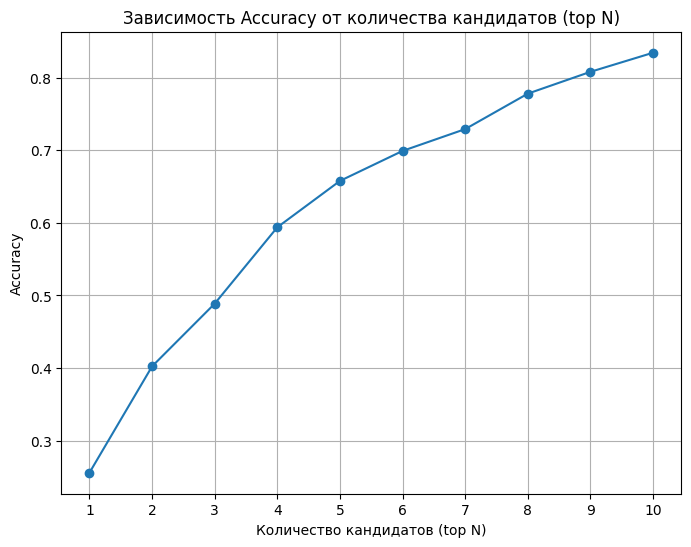

In [84]:
# Модель NearestNeighbors для поиска ближайших товаров с косинусной метрикой
top_candidates = 10  # максимальное количество кандидатов, которое будем получать для дальнейшей оценки
nn_model = NearestNeighbors(n_neighbors=top_candidates, metric='cosine')
nn_model.fit(tfidf_us)

results = []  # список словарей с информацией для каждого запроса


for idx, row in df_match.iterrows():
    competitor_name = row['name']
    target = row['target']
    predictions = get_top_n_products(competitor_name, n=top_candidates)
    # Определим позицию, на которой находится target (если отсутствует, запишем None)
    positions = [i for i, (prod, sim) in enumerate(predictions, start=1) if prod == target]
    pos = positions[0] if positions else None
    results.append({'competitor': competitor_name, 'target': target, 'predictions': predictions, 'position': pos})
    
# Теперь вычислим accuracy для диапазона N от 1 до top_candidates.
top_n_values = range(1, top_candidates + 1)
accuracies = []

for n in top_n_values:
    correct = 0
    total = len(results)
    for res in results:
        # Если target находится на позиции <= n, то считаем корректным предсказанием.
        if res['position'] is not None and res['position'] <= n:
            correct += 1
    accuracy = correct / total
    accuracies.append(accuracy)
    print(f"Top-{n}: Accuracy = {accuracy:.2%}")

# Строим график зависимости accuracy от top-N
plt.figure(figsize=(8, 6))
plt.plot(list(top_n_values), accuracies, marker='o', linestyle='-')
plt.xlabel('Количество кандидатов (top N)')
plt.ylabel('Accuracy')
plt.title('Зависимость Accuracy от количества кандидатов (top N)')
plt.grid(True)
plt.xticks(list(top_n_values))
plt.show()

Видно, что несмотря на низкую точность отдельного предсказания, точность быстро растет с ростом окна N.

Были опробованы и другие более сложные варианты токенизатора, рассмотрены отдельно числа и слова с разными весами, после поиска лучших вариантов моделью ближайших соседей добавлялся второй уровень с использованием библиотеки fasttext. Но метрика у всех этих вариантов была ниже чем у самого простого ванианта , приведенного выше.

Посмотрим теперь на распределение косинусного сходства по датасетам df и df_match

In [85]:
def sims_graph(df):# Сбор значений сходства
    similarities = []
    for name in tqdm(df['name']):
        vec = vectorizer.transform([name])
        dists, _ = nn_model.kneighbors(vec, n_neighbors=1)
        sims = (1 - dists[0]).tolist()
        similarities.extend(sims)

    # Рисуем гистограмму распределения сходства
    plt.figure(figsize=(8, 6))
    plt.hist(similarities, bins=25)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.title('Распределение косинусного сходства предсказаний')
    plt.grid(True)
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 266/266 [00:02<00:00, 128.96it/s]


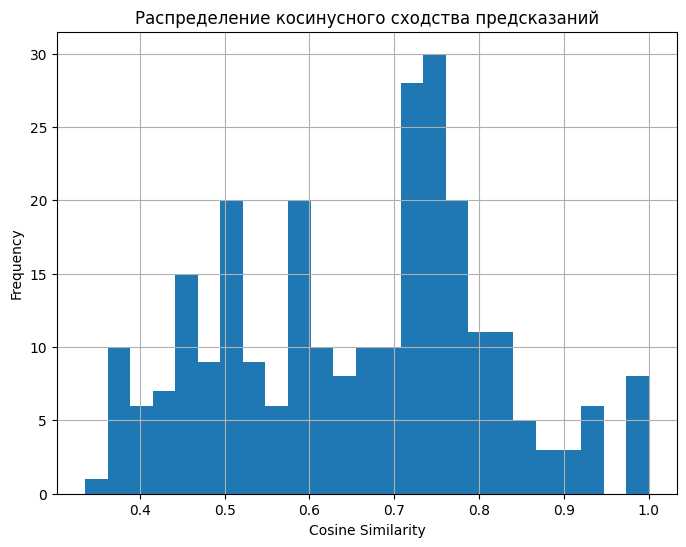

In [86]:
sims_graph(df_match)

100%|███████████████████████████████████████████████████████████████████████████| 43632/43632 [05:38<00:00, 129.03it/s]


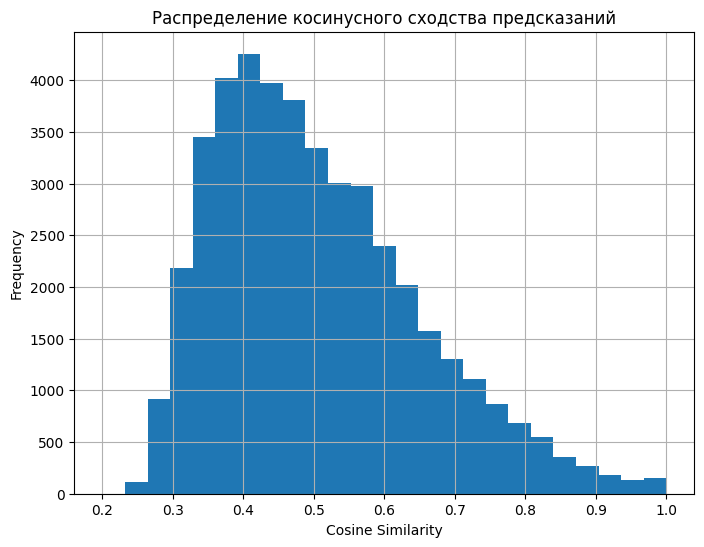

In [87]:
sims_graph(df)

Из этих распределений понятно, что точность на реальных данных будет значительно ниже и это не удивительно т.к. сметченные позиции выбирались не случайно.

### Вывод 

Для решения задачи поиска наиболее близких товаров были обработаны предоставленные файлы данных. Было принято решение анализировать только строку названия товара. Были объеденения данные из следующих групп файлов

- Товары конкурентов (слухи и парсинг - источник).csv 
- Товары конкурентов (счета - источник).csv

также

- Список наших товаров.csv
- Наши товары с артикулом.csv
- Наши товары с категорями.xls

и

- Сметченные позиции 1.csv
- Сметченные позиции 2.csv
- Сметченные_позиции_слухи_и_парсинг_2_0_с_наименованием.csv
- Сметченные_счета_с_наименованиями.csv

Затем была обучена модель для предсказания, которая состоит из TF-IDF векторизации и модели ближайших соседей работающей на этой векторизации с метрикой косинусного сходства.  
Метрика accuracy на тестовых данных составила 25.6% на одиночном предсказании и 65.8% на выборке из топ-5.

Для улучшения качества модели следующие рекомендации: увеличить датасет со сметченными товарами и повысить его достоверность, проверить полноту описаний товаров. 